In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from math import sqrt

from data_preperation import prepare_data
from constants import random_seed

%matplotlib inline

In [2]:
# We set a fixed seed for repeatability
torch.manual_seed(random_seed)

# Your first task as a Data Scientist
You just started in your new job as Data Scientist at Awesome Corp. One of the customers recently had a temporary sensor failure causing the loss of very valuable flow rate data. They need an accurate estimate of the missing flow rates ASAP so that they can optimize their system. Naturally, you are given the job since you have mastered deep learning.

### Here is the brief!

You need to estimate the total flow of oil, gas, and water through a choke valve. The total flow rate is labeled `QTOT`. You should use all measurements that may explain the total flow. Awesome Corp has already prepared these for you in a dataset (no further preprocessing is required). The measurements (features) are labeled as follows:
- `CHK`: choke opening - a number in [0, 1], 1 meaning fully open and 0 meaning closed
- `PWH`: pressure upstream the choke (scaled)
- `PDC`: pressure downstream the choke (scaled)
- `TWH`: temperature upstream the choke (scaled)
- `FGAS`: fraction of gas to total flow - a number in [0,1]
- `FOIL`: fraction of water to total flow - a number in [0,1]

The location of the sensors are shown in the figure below.

<img src="../resources/well_sensors.png">

### Wait! There is one issue. The customer does not have a model for the total flow rate...

A simple choke model for water flow is:
$$QTOT = C_v(CHK) \sqrt{\frac{2(PWH - PDC)}{\rho}}$$
where $C_v(CHK)$ gives the cross-sectional area as a function of choke opening `CHK`.

Unfortunately, there are complications that prevent us from using this model:

1. We do not know what the correct equations are for multi-phase flow. For example, we expect gas expansions to be a factor. This factor is likely dependent on the temperature `TWH` and the amount of gas `FGAS`. Viscosity is probably a factor too, and that would depend on `FOIL`.
2. We do not know the form of the choke $C_v$-curve.

[Head scratch] Perhaps we can use a deep learning algorithm to learn a good representation of the data? Let us try to use all the available measurements to model `QTOT` using a neural network:
$$QTOT = f_{\theta}(CHK, PWH, PDC, TWH, FGAS, FOIL)$$

Let's get to work!


# Split the data into a train, validation and test set, and construct data loaders

Our test set consists of the examples indexed by [2000, 2499]. Our task is to estimate `QTOT` for this period.

The rest of the data is split into a train (90%) and validation set (10%). We draw the validation data randomly.

In [3]:
# Declare features
INPUT_COLS = ['CHK', 'PWH', 'PDC', 'TWH', 'FGAS', 'FOIL']
OUTPUT_COLS = ['QTOT']

# Load processed data
train_loader, x_val, y_val, val_loader, x_test, y_test = prepare_data(INPUT_COLS, OUTPUT_COLS)

# Neural network

Here we specify how to construct our neural network $f_{\theta}$. 

We use ReLU activation for the hidden layers:
$$h^{(i)} = ReLU(W^{(i)} h^{(i-1)} + b^{(i)})$$

The output layer is a simple linear layer since we will solve a regression problem.

We use He initialization for the weights. The biases are initialized to zero.

In [4]:
class Net(torch.nn.Module):
    """
    PyTorch offers several ways to construct neural networks.
    Here we choose to implement the network as a Module class.
    This gives us full control over the construction and clarifies our intentions.
    """
    
    def __init__(self, layers):
        """
        Constructor of neural network
        :param layers: list of layer widths. Note that len(layers) = network depth + 1 since we incl. the input layer.
        """
        super().__init__()

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        assert len(layers) >= 2, "At least two layers are required (incl. input and output layer)"
        self.layers = layers

        # Fully connected linear layers
        linear_layers = []

        for i in range(len(self.layers) - 1):
            n_in = self.layers[i]
            n_out = self.layers[i+1]
            layer = torch.nn.Linear(n_in, n_out)

            # Initialize weights and biases
            a = 1 if i == 0 else 2
            layer.weight.data = torch.randn((n_out, n_in)) * sqrt(a / n_in)
            layer.bias.data = torch.zeros(n_out)
            
            # Add to list
            linear_layers.append(layer)
        
        # Modules/layers must be registered to enable saving of model
        self.linear_layers = torch.nn.ModuleList(linear_layers)  

        # Non-linearity (e.g. ReLU, ELU, or SELU)
        self.act = torch.nn.ReLU(inplace=False)

    def forward(self, input):
        """
        Forward pass to evaluate network for input values
        :param input: tensor assumed to be of size (batch_size, n_inputs)
        :return: output tensor
        """
        x = input
        for l in self.linear_layers[:-1]:
            x = l(x)
            x = self.act(x)

        output_layer = self.linear_layers[-1]
        return output_layer(x)

    def get_num_parameters(self):
        return sum(p.numel() for p in self.parameters())

    def save(self, path: str):
        """
        Save model state
        :param path: Path to save model state
        :return: None
        """
        torch.save({
            'model_state_dict': self.state_dict(),
        }, path)

    def load(self, path: str):
        """
        Load model state from file
        :param path: Path to saved model state
        :return: None
        """
        checkpoint = torch.load(path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        self.load_state_dict(checkpoint['model_state_dict'])

# Training loop

Below we implement the training procedure for the neural network. 

We loop over batches in the dataset (one pass through the dataset is called an _epoch_).

For each batch B, we do a forward pass to compute the cost function:
$$J(\theta) = \frac{1}{|B|} \sum_{i \in B} (y_i - f_{\theta}(x_i))^2 + \lambda \lVert \theta \rVert_2^2$$

We then do a backward pass to compute the gradient:
$$\frac{\partial J}{\partial \theta}$$

Finally, we update the parameters:
$$\theta \leftarrow \theta - \alpha \frac{\partial J}{\partial \theta}$$

Note that we use Adam so the update rule is actually a bit different than the one above.

In [5]:
def train(
        net: torch.nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        n_epochs: int,
        lr: float,
        l2_reg: float,
) -> torch.nn.Module:
    """
    Train model using mini-batch SGD
    After each epoch, we evaluate the model on validation data

    :param net: initialized neural network
    :param train_loader: DataLoader containing training set
    :param n_epochs: number of epochs to train
    :param lr: learning rate (default: 0.001)
    :param l2_reg: L2 regularization factor (default: 0)
    :return: torch.nn.Module: trained model.
    """

    # Define loss and optimizer
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    # Train Network
    for epoch in range(n_epochs):
        #TODO: initialize new epoc directory

        for inputs, labels in train_loader:
            # Zero the parameter gradients (from last iteration)
            optimizer.zero_grad()

            # Forward propagation
            outputs = net(inputs)
            
            # Compute cost function
            batch_mse = criterion(outputs, labels)
            
            reg_loss = 0
            for param in net.parameters():
                reg_loss += param.pow(2).sum()

            cost = batch_mse + l2_reg * reg_loss

            # Backward propagation to compute gradient
            cost.backward()
            
            # Update parameters using gradient
            optimizer.step()
        
        # Evaluate model on validation data
        mse_val = 0
        for inputs, labels in val_loader:
            mse_val += torch.sum(torch.pow(labels - net(inputs), 2)).item()
        mse_val /= len(val_loader.dataset)
        print(f'Epoch: {epoch + 1}: Val MSE: {mse_val}')

        #TODO: Save model to epoc directory
        #TODO: Save some other shit if not possible to calculate afterwords
    #TODO: Save final model
    return net

# Construct and initialize the model

The time to construct an actual neural network has finally come! 

Now, what should the network size be? How much data do we have? How nonlinear is the underlying function we are trying to model? Two to hidden layers with 50 units may be sufficient? Let's try that.

In [6]:
layers = [len(INPUT_COLS), 50, 50, len(OUTPUT_COLS)]
net = Net(layers)

print(f'Layers: {layers}')
print(f'Number of model parameters: {net.get_num_parameters()}')
# print(6*50 + 50 + 50*50 + 50 + 50 * 1 + 1)

Layers: [6, 50, 50, 1]
Number of model parameters: 2951


# Train the model

Almost there. We only need to set some important hyper-parameters before we start the training. The number of epochs to train, the learning rate, and the L2 regularization factor.

In [7]:
n_epochs = 100
lr = 0.001
l2_reg = 0.001  # 10
net = train(net, train_loader, val_loader, n_epochs, lr, l2_reg)

Epoch: 1: Val MSE: 60.71314978966346
Epoch: 2: Val MSE: 35.93435621995192
Epoch: 3: Val MSE: 14.697877854567308
Epoch: 4: Val MSE: 9.562464317908654
Epoch: 5: Val MSE: 8.629805814302884
Epoch: 6: Val MSE: 7.7899029071514425
Epoch: 7: Val MSE: 7.162307974008414
Epoch: 8: Val MSE: 7.143041522686298
Epoch: 9: Val MSE: 7.046303147536058
Epoch: 10: Val MSE: 6.8768451397235575
Epoch: 11: Val MSE: 6.8789621206430285
Epoch: 12: Val MSE: 6.855525090144231
Epoch: 13: Val MSE: 6.810156719501202
Epoch: 14: Val MSE: 6.879619422325721
Epoch: 15: Val MSE: 7.505840594951923
Epoch: 16: Val MSE: 6.6348045935997595
Epoch: 17: Val MSE: 6.805615703876202
Epoch: 18: Val MSE: 7.149059119591346
Epoch: 19: Val MSE: 6.7161376953125
Epoch: 20: Val MSE: 7.0682096041165865
Epoch: 21: Val MSE: 6.57257080078125
Epoch: 22: Val MSE: 6.853449894831731
Epoch: 23: Val MSE: 6.45419921875
Epoch: 24: Val MSE: 6.333028001051683
Epoch: 25: Val MSE: 6.348884934645433
Epoch: 26: Val MSE: 6.319796987680289
Epoch: 27: Val MSE: 7.

# Evaluate the model on validation data

In [8]:
# Predict on validation data
pred_val = net(x_val)

# Compute MSE, MAE and MAPE on validation data
print('Error on validation data')

mse_val = torch.mean(torch.pow(pred_val - y_val, 2))
print(f'MSE: {mse_val.item()}')

mae_val = torch.mean(torch.abs(pred_val - y_val))
print(f'MAE: {mae_val.item()}')

mape_val = 100*torch.mean(torch.abs(torch.div(pred_val - y_val, y_val)))
print(f'MAPE: {mape_val.item()} %')

Error on validation data
MSE: 5.2273850440979
MAE: 1.6862919330596924
MAPE: 6.6564178466796875 %


# Are you happy with the result? 

Remember that the validation error is just an estimate of the test error (the error on new examples). The test error may be higher or lower. We may proceed if we believe that we have a good validation set and the validation error is sufficiently low.

If we wish to proceed, a final step before we produce our estimates would be to re-train the model on both the train and validation data. We will skip this step for now.

Let's see how well we did!

# Evaluate the model on test data

In [9]:
# Make prediction
pred_test = net(x_test)

# Compute MSE, MAE and MAPE on test data
print('Error on test data')

mse_test = torch.mean(torch.pow(pred_test - y_test, 2))
print(f'MSE: {mse_test.item()}')

mae_test = torch.mean(torch.abs(pred_test - y_test))
print(f'MAE: {mae_test.item()}')

mape_test = 100*torch.mean(torch.abs(torch.div(pred_test - y_test, y_test)))
print(f'MAPE: {mape_test.item()} %')

Error on test data
MSE: 1.9076869487762451
MAE: 0.9811860918998718
MAPE: 3.1949329376220703 %


# Visual evaluation

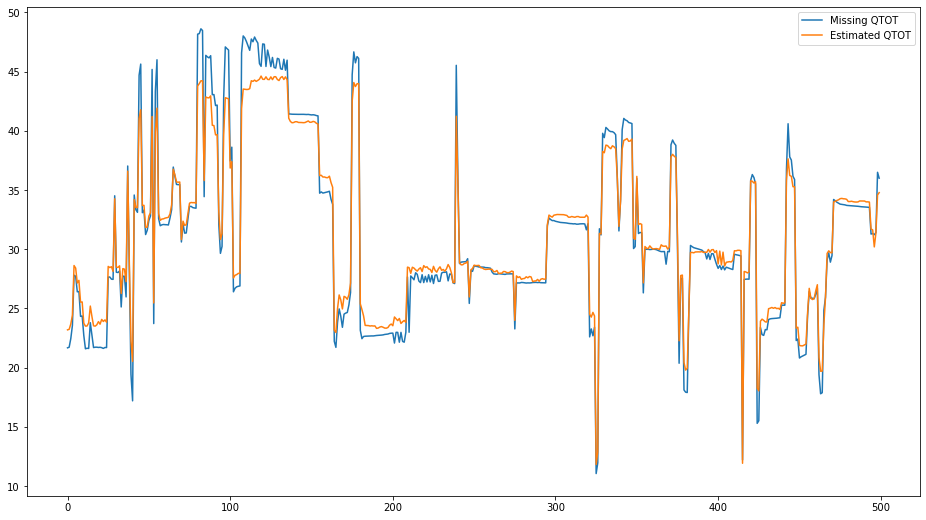

In [10]:
plt.figure(figsize=(16, 9))
plt.plot(y_test.numpy(), label='Missing QTOT')
plt.plot(pred_test.detach().numpy(), label='Estimated QTOT')
plt.legend()

# That's pretty good! 

But this is only the beginning. We have only set up the framework. Now you can be creative and experiment with different architectures, regularization techniques and hyper-parameters. I challenge you not to keep staring at those training curves as you wait for the result of a cool new idea - I am still hypnotized by them :-)